In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import zipfile

from torch.utils.data import Dataset, DataLoader
from io import BytesIO

In [2]:
def download_and_unzip(url, save_folder):
    # Ensure the save folder exists
    os.makedirs(save_folder, exist_ok=True)

    # Download the file
    print(f"Downloading file from {url}...")
    response = requests.get(url)
    if response.status_code == 200:
        print("Download successful!")
        file_bytes = BytesIO(response.content)

        # Check if the file is a zip
        if zipfile.is_zipfile(file_bytes):
            print("Extracting zip file...")
            with zipfile.ZipFile(file_bytes, 'r') as zip_ref:
                zip_ref.extractall(save_folder)
            print(f"Files extracted to {save_folder}")
        else:
            print("The downloaded file is not a zip file.")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")

In [3]:
class SequentialDataset(Dataset):
    def __init__(self, user_item_data, pad_value, max_seq_len=10):
        self.data = user_item_data
        self.max_seq_len = max_seq_len
        self.pad_value = pad_value

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data.iloc[idx]
        seq = data['Seq'][-(self.max_seq_len + 1):]
        seq_tensor = torch.LongTensor(seq[:-1])
        seq_tensor_len = seq_tensor.shape[0]
        pad_len = self.max_seq_len - seq_tensor_len
        seq_tensor_padded = F.pad(seq_tensor, (0, pad_len), mode='constant', value=self.pad_value)
        target_tensor = torch.LongTensor([seq[-1]])
        return seq_tensor_padded, target_tensor, data['UserID']

In [4]:
# url = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
save_folder = "../data/"

# download_and_unzip(url, save_folder)

In [5]:
movie_data = pd.read_csv(
    os.path.join(save_folder, 'ml-100k/u.data'),
    sep='\t',
    header=None,
    names=["UserID", "ItemID", "Rating", "Timestamp"]
)


In [6]:
# Sort by timestamp to create sequential data
movie_data["Timestamp"] = pd.to_datetime(movie_data["Timestamp"], unit='s')
movie_data = movie_data.sort_values(by=["UserID", "Timestamp"])

In [7]:
# pad_value = max(movie_data['ItemID']) + 1
pad_value = 0

In [8]:
# Generate cumulative lists
def generate_cumulative_list(group):
    cumulative_list = []
    result = []
    for item in group:
        # Add the current item to the cumulative list
        cumulative_list.append(item)
        # Append the cumulative list before the current item
        result.append(list(cumulative_list))
    return result

movie_data['Seq'] = movie_data.groupby('UserID')['ItemID'].transform(generate_cumulative_list)

In [9]:
# Get records with 6+ interactions
movie_data = movie_data.loc[movie_data.Seq.apply(len) > 5]

In [10]:
# Use the last item in each sequence as a test sample
movie_data['IsTest'] = movie_data.groupby('UserID')['Timestamp'].transform(lambda x: x == x.max())

In [11]:
movie_data_train = movie_data.loc[~movie_data.IsTest, ['UserID', 'Seq']]
movie_data_test = movie_data.loc[movie_data.IsTest, ['UserID', 'Seq']]

In [12]:
# shuffle the data
movie_data_train = movie_data_train.sample(frac=1).reset_index(drop=True)

In [13]:
# Dataset and DataLoader
max_seq_len = 10
train_dataset = SequentialDataset(movie_data_train, pad_value=pad_value, max_seq_len=max_seq_len)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [14]:
test_dataset = SequentialDataset(movie_data_test, pad_value=pad_value, max_seq_len=max_seq_len)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [15]:
# SASRec Model
class SASRec(nn.Module):
    def __init__(self, num_items, embedding_dim, num_heads, max_seq_len, pad_value, dropout_rate=0.2):
        super(SASRec, self).__init__()
        self.pad_value = pad_value
        self.item_embedding = nn.Embedding(
            num_items, embedding_dim, padding_idx=self.pad_value)
        self.positional_encoding = nn.Embedding(max_seq_len, embedding_dim)
        self.dropout = nn.Dropout(dropout_rate)

        # Transformer Encoder with dropout
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dropout=dropout_rate
        )
        self.attention = nn.TransformerEncoder(encoder_layer, num_layers=4)

        self.fc = nn.Linear(embedding_dim, num_items)

    def forward(self, seq, pos):
        """
        Forward pass for SASRec.
        Args:
            seq (torch.LongTensor): Input sequence of item IDs.
            pos (torch.LongTensor): Positional indices for the sequence.

        Returns:
            torch.Tensor: Prediction logits for the next item.
        """
        # Apply item and positional embeddings with dropout
        item_emb = self.item_embedding(seq)
        pos_emb = self.positional_encoding(pos)
        x = self.dropout(item_emb + pos_emb)  # Apply dropout after embeddings

       # Create attention mask (ignore padding)
        attention_mask = (seq != self.pad_value)  # Shape: [BatchSize, SeqLen]
        attention_mask = attention_mask.unsqueeze(
            1).unsqueeze(2)  # Shape: [BatchSize, 1, 1, SeqLen]

        # Transformer Encoder
        x = x.permute(1, 0, 2)  # [SeqLen, BatchSize, EmbDim]
        attention_out = self.attention(
            x, src_key_padding_mask=~attention_mask.squeeze(1).squeeze(1))
        # Fully connected layer with dropout
        # Only predict for the last item
        output = self.fc(self.dropout(attention_out[-1]))
        return output

In [16]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='checkpoint.pth', verbose=False):
        """
        EarlyStopping class to stop training when validation loss does not improve.

        Args:
            patience (int): How many epochs to wait after last time validation loss improved.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            path (str): Path to save the model checkpoint.
            verbose (bool): If True, prints a message for each validation loss improvement.
        """
        self.patience = patience
        self.delta = delta
        self.path = path
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [17]:
def masked_loss(outputs, targets, pad_value):
    """
    Computes the loss while ignoring padding tokens.

    Args:
        outputs (torch.Tensor): Model outputs (logits) of shape [BatchSize, NumItems].
        targets (torch.Tensor): Target item IDs of shape [BatchSize].
        padding_value (int): Value used for padding (default is -1).
    Returns:
        torch.Tensor: Loss value.
    """
    mask = (targets != pad_value)  # Create mask to ignore padding
    masked_outputs = outputs[mask]
    masked_targets = targets[mask]
    return F.cross_entropy(masked_outputs, masked_targets)

In [22]:
# Model initialization
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
num_items = max(movie_data['ItemID']) + 1
sasrec = SASRec(num_items=num_items, embedding_dim=32,
                num_heads=4, max_seq_len=max_seq_len, pad_value=0, dropout_rate=0.1).to(device)
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(sasrec.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=3, delta=0.01, verbose=True)

/Users/vaclavcepelak/miniconda3/envs/vc_playground/lib/python3.11/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [23]:
losses = []
print_every = 100
n_epochs = 100
# Training Loop
for epoch in range(n_epochs):
    sasrec.train()
    train_loss = 0
    for i, (seq, target, _) in enumerate(train_dataloader):
        seq = seq.to(device)
        pos = torch.arange(seq.size(1)).unsqueeze(0).to(device)  # Positional indices
        target = target.to(device)
        optimizer.zero_grad()
        outputs = sasrec(seq, pos)
        loss = masked_loss(outputs, target.view(-1), pad_value=pad_value)
        losses.append(loss.item())
        train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(sasrec.parameters(), max_norm=1.0)
        optimizer.step()

        # Print loss every 'print_every' batches
        if (i + 1) % print_every == 0:
            print(f"Epoch [{epoch + 1}/{n_epochs}], Batch [{i + 1}/{len(train_dataloader)}], Loss: {loss.item():.4f}")
    
    # Compute average training loss
    train_loss /= len(train_dataloader)

    # Validation phase
    sasrec.eval()
    val_loss = 0
    with torch.no_grad():
        for seq, target, _ in test_dataloader:
            seq, target = seq.to(device), target.to(device)
            pos = torch.arange(seq.size(1)).unsqueeze(
                0).expand(seq.size(0), -1).to(device)
            outputs = sasrec(seq, pos)
            loss = masked_loss(outputs, target.view(-1), pad_value=pad_value)
            val_loss += loss.item()

    # Compute average validation loss
    val_loss /= len(test_dataloader)

    print(
        f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Check early stopping
    early_stopping(val_loss, sasrec)

    if early_stopping.early_stop:
        print("Early stopping")
        break

# Load the best model checkpoint
sasrec.load_state_dict(torch.load('checkpoint.pth'))

Epoch [1/100], Batch [100/1456], Loss: 7.1236
Epoch [1/100], Batch [200/1456], Loss: 6.9648
Epoch [1/100], Batch [300/1456], Loss: 6.7099
Epoch [1/100], Batch [400/1456], Loss: 6.7457
Epoch [1/100], Batch [500/1456], Loss: 6.8841
Epoch [1/100], Batch [600/1456], Loss: 6.8927
Epoch [1/100], Batch [700/1456], Loss: 6.9795
Epoch [1/100], Batch [800/1456], Loss: 6.6828
Epoch [1/100], Batch [900/1456], Loss: 6.8430
Epoch [1/100], Batch [1000/1456], Loss: 6.9058
Epoch [1/100], Batch [1100/1456], Loss: 6.5964
Epoch [1/100], Batch [1200/1456], Loss: 6.6398
Epoch [1/100], Batch [1300/1456], Loss: 6.7358
Epoch [1/100], Batch [1400/1456], Loss: 6.8207
Epoch 1, Train Loss: 6.8493, Val Loss: 6.8789
Validation loss decreased (inf --> 6.878867).  Saving model ...
Epoch [2/100], Batch [100/1456], Loss: 6.9052
Epoch [2/100], Batch [200/1456], Loss: 6.7875
Epoch [2/100], Batch [300/1456], Loss: 6.7444
Epoch [2/100], Batch [400/1456], Loss: 6.8236
Epoch [2/100], Batch [500/1456], Loss: 6.7147
Epoch [2/10

/var/folders/fy/py9cfy7s3d753k3fsbhh5nbm0000gn/T/ipykernel_56152/1067305820.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sasrec.load_state_dict(torch.load('checkpoin

<All keys matched successfully>

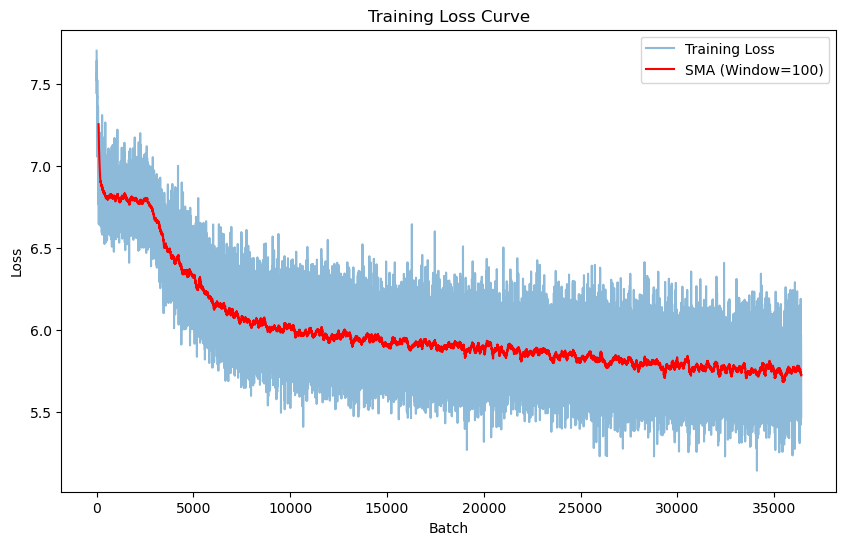

In [24]:
# Simple Moving Average (SMA) Smoothing Function
def moving_average(values, window_size):
    """
    Computes the simple moving average (SMA) of a list of values.

    Args:
        values (list or np.array): The original list of values.
        window_size (int): The number of points to average over.
    Returns:
        np.array: The smoothed values (same length as input, with NaNs for the first few points).
    """
    sma = np.convolve(values, np.ones(window_size) / window_size, mode='valid')

    # Pad the beginning with NaNs to keep the same length as the original list
    padded_sma = np.concatenate((np.full(window_size - 1, np.nan), sma))
    return padded_sma


# Example usage
window_size = 100  # Adjust the window size based on your data

# Plot the raw and SMA-smoothed loss curves
plt.figure(figsize=(10, 6))
plt.plot(losses, label="Training Loss", alpha=0.5)  # Raw loss
plt.plot(moving_average(losses, window_size),
         label=f"SMA (Window={window_size})", color='red')  # Smoothed loss
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

In [25]:
sasrec.eval()

SASRec(
  (item_embedding): Embedding(1683, 32, padding_idx=0)
  (positional_encoding): Embedding(10, 32)
  (dropout): Dropout(p=0.1, inplace=False)
  (attention): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=32, out_features=1683, bias=True)
)

In [26]:
def get_predictions(loader, top_k):
    predictions = {}
    ground_truths = {}
    
    # Generate predictions
    with torch.no_grad():
        for seq, target, users in loader:
            pos = torch.arange(seq.size(1)).unsqueeze(0)  # Positional indices
            logits = sasrec(seq, pos)  # Predict scores for all items
            top_k_preds = torch.topk(
                logits, k=top_k, dim=1).indices  # Top-k predictions

            # Save predictions and ground truths
            for preds, gt, user in zip(top_k_preds, target, users):
                user_ix = user.item()
                predictions[user_ix] = preds.cpu().tolist()
                ground_truths[user_ix] = gt.item()
    
    return predictions, ground_truths

In [27]:
test_predictions, test_ground_truths = get_predictions(test_dataloader, 5)
train_predictions, train_ground_truths = get_predictions(train_dataloader, 5)

RuntimeError: Placeholder storage has not been allocated on MPS device!

In [ ]:
# Metrics computation
def recall_at_k(predictions, ground_truths, k):
    recalls = []
    for user, preds in predictions.items():
        gt = ground_truths[user]
        recalls.append(int(gt in preds[:k]))
    return np.mean(recalls)


def precision_at_k(predictions, ground_truths, k):
    precisions = []
    for user, preds in predictions.items():
        gt = ground_truths[user]
        precisions.append(int(gt in preds[:k]) / k)
    return np.mean(precisions)


def mean_reciprocal_rank(predictions, ground_truths):
    mrrs = []
    for user, preds in predictions.items():
        gt = ground_truths[user]
        if gt in preds:
            rank = preds.index(gt) + 1
            mrrs.append(1 / rank)
        else:
            mrrs.append(0)
    return np.mean(mrrs)


def ndcg_at_k(predictions, ground_truths, k):
    ndcgs = []
    for user, preds in predictions.items():
        gt = ground_truths[user]
        dcg = 0
        for i, pred in enumerate(preds[:k]):
            if pred == gt:
                dcg = 1 / np.log2(i + 2)  # Discounted gain
                break
        idcg = 1 / np.log2(1 + 1)  # Ideal DCG
        ndcgs.append(dcg / idcg)
    return np.mean(ndcgs)

In [ ]:
# Compute metrics
k = 10
test_recall = recall_at_k(test_predictions, test_ground_truths, k)
test_precision = precision_at_k(test_predictions, test_ground_truths, k)
test_mrr = mean_reciprocal_rank(test_predictions, test_ground_truths)
test_ndcg = ndcg_at_k(test_predictions, test_ground_truths, k)
train_recall = recall_at_k(train_predictions, train_ground_truths, k)
train_precision = precision_at_k(train_predictions, train_ground_truths, k)
train_mrr = mean_reciprocal_rank(train_predictions, train_ground_truths)
train_ndcg = ndcg_at_k(train_predictions, train_ground_truths, k)

print(f"Recall@{k} - Train: {train_recall:.4f}; Test: {test_recall:.4f}")
print(f"Precision@{k} - Train: {train_precision:.4f}; Test: {test_precision:.4f}")
print(f"NDCG@{k} - Train: {train_ndcg:.4f}; Test: {test_ndcg:.4f}")
print(f"MRR - Train: {train_mrr:.4f}; Test: {test_mrr:.4f}")